# Kaggle competition [Sberbank Russian Housing Market](https://www.kaggle.com/c/sberbank-russian-housing-market)

### Steps followed:
- Read train and test data
- Add macro features to these datasets
- Exploratory analysis on features available 
- Feature Engineering
- Validation Strategy Cross Validation
- Parameter tuning
- Scoring and Submission

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from six.moves import cPickle as pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer

color = sns.color_palette()

%matplotlib inline

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_df = pd.read_csv("train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'])
train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')
print(train_df.shape, test_df.shape)

(30471, 391) (7662, 390)


In [3]:
#output files
pickle_file = 'Xgb_4.pickle'
output_file = 'sub_4.csv'

# Simple Exploration

Check the variables and their datatypes

In [4]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,159
1,datetime64[ns],1
2,float64,213
3,object,18


So there are 391 variables out of which majoity are numeric and a small percentage are categorical

## Explore the target variable first and check for outliers or patterns

generate a scatter plot for the target variable

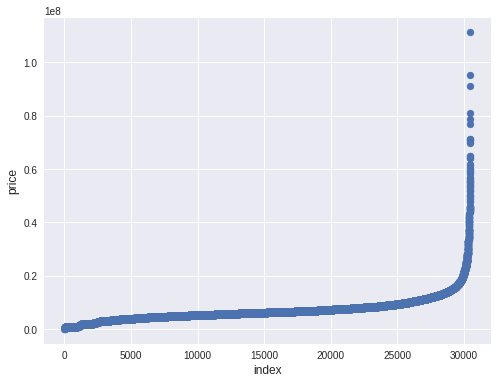

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(list(range(train_df.shape[0])), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

This looks piecewise linear and it can be utilized later when we think of stacking models or preparing multiple models.

Since we will evaluate our model with RSMLE so it is better to get a scatter plot with log og target variable also

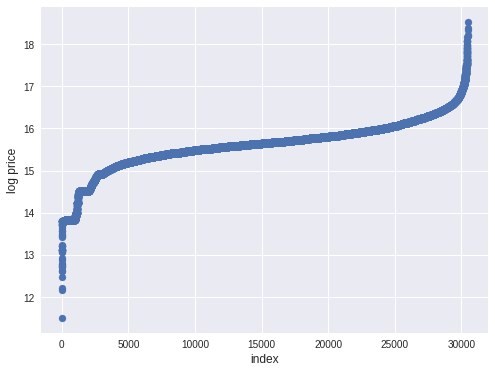

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(list(range(train_df.shape[0])), np.log1p(np.sort(train_df.price_doc.values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('log price', fontsize=12)
plt.show()

Now let's look into distrubution plots of price_doc and log of price_doc

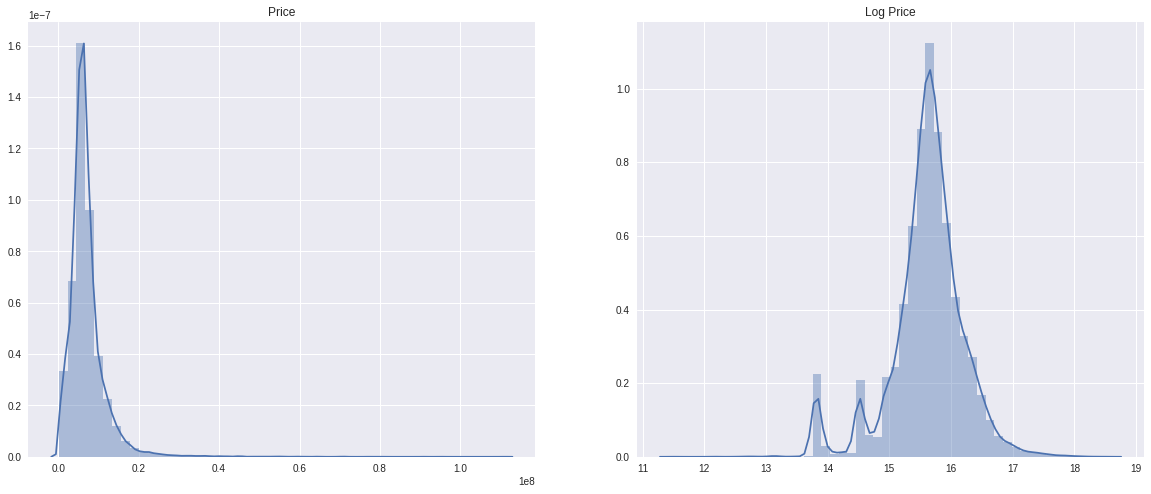

In [7]:
# Two subplots
f, (ax1, ax2) = plt.subplots(1, 2)
sns.distplot(train_df.price_doc.values,bins = 50, kde = True, ax= ax1)
sns.distplot(np.log1p(train_df.price_doc.values),bins = 50, kde = True, ax= ax2)

ax1.set_title('Price')
ax2.set_title('Log Price')
ax1.figure.set_size_inches(20, 8)
ax2.figure.set_size_inches(20, 8)

plt.show()

Price is positively skewed as it has much longer tail which is not the case with log price

Now let's check how the median price changes over time in the given data set

In [8]:
train_df['yearmonth'] = train_df['timestamp'].astype(str).apply(lambda x: x[:4]+x[5:7])
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

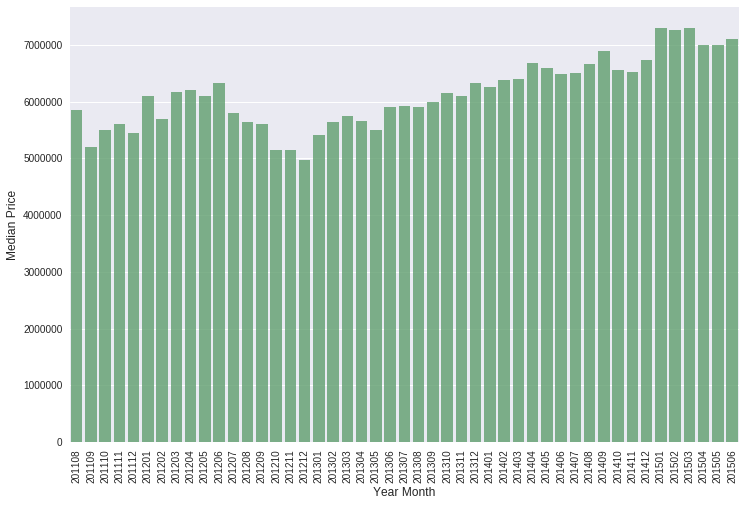

In [9]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[1])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Let us explore the number of missing values in each column.

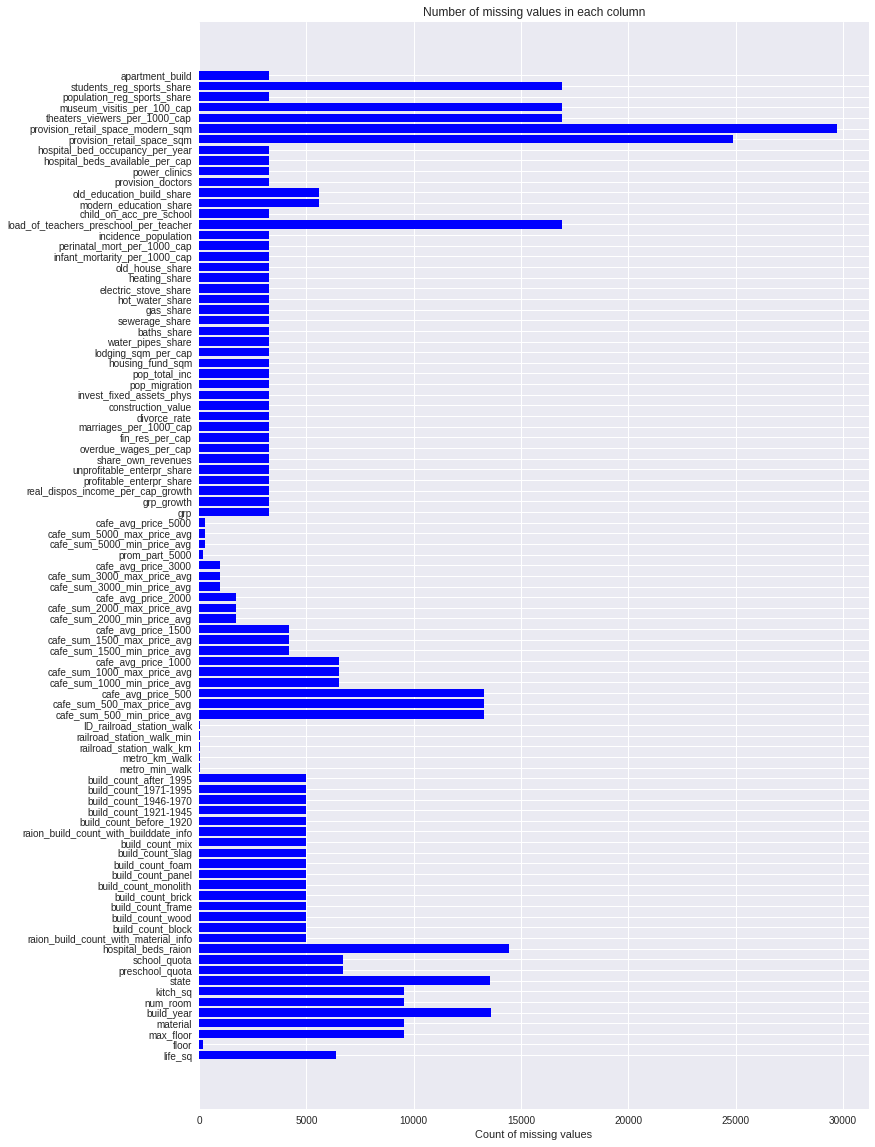

In [10]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,20))
rects = ax.barh(ind, missing_df.missing_count.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Looks like the variables have missing values in groups

Run a model and check the important features 

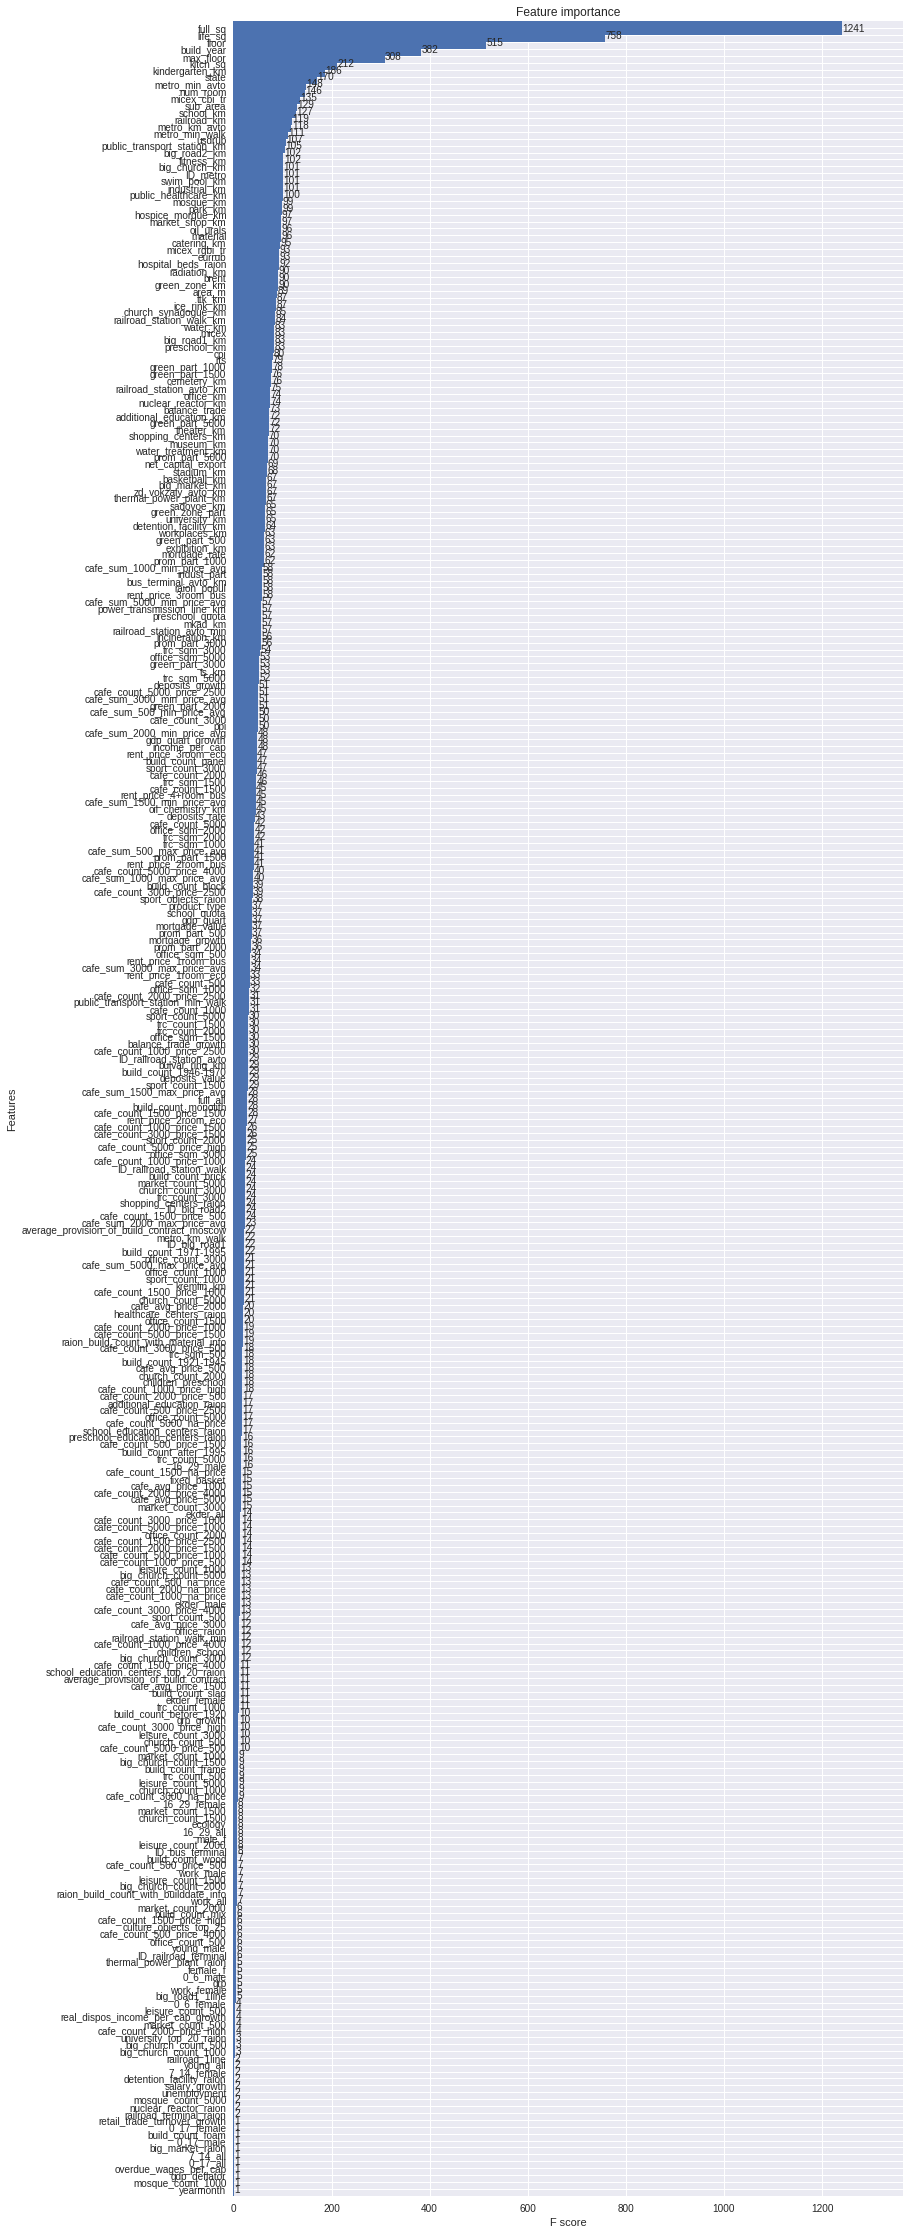

In [11]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,40))
xgb.plot_importance(model, height=2, ax=ax)
plt.show()

So the top 5 feaures are
1. *full_sq* - total area in square meters, including loggias, balconies and other non-residential areas
2. *life_sq* -  living area in square meters, excluding loggias, balconies and other non-residential areas
3. *floor*   - for apartments, floor of the building
4. *build_year* - year built
5. *max_floor*  - number of floors in the building


Now let us see how these important variables are distributed with respect to target variable.

** Total Area in square meters: **

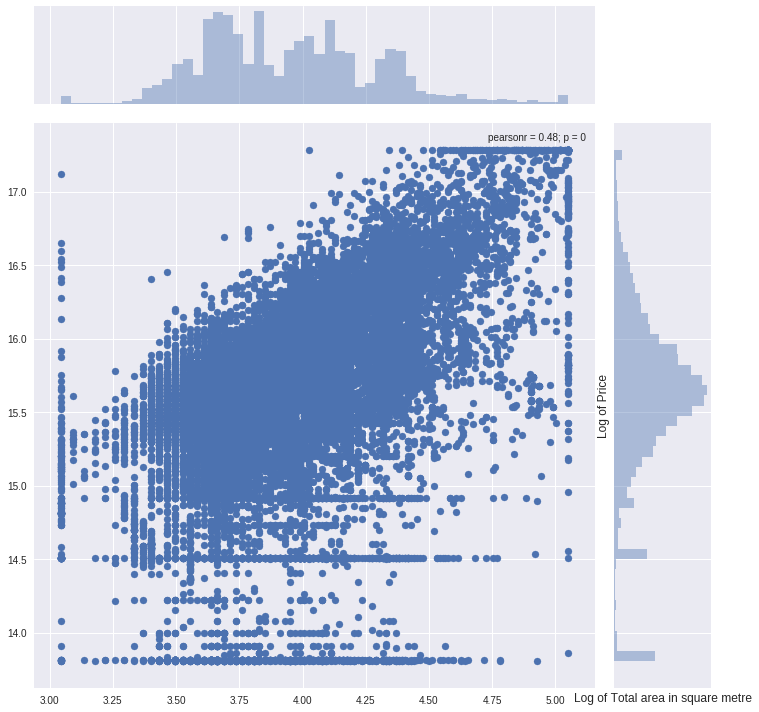

In [12]:
ulimit = np.percentile(train_df.price_doc.values, 99.5)
llimit = np.percentile(train_df.price_doc.values, 0.5)
train_df.loc[train_df['price_doc']>ulimit,'price_doc'] = ulimit
train_df.loc[train_df['price_doc']<llimit,'price_doc'] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df.loc[train_df[col]>ulimit,col] = ulimit
train_df.loc[train_df[col]<llimit,col] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()

** Living area in square meters **

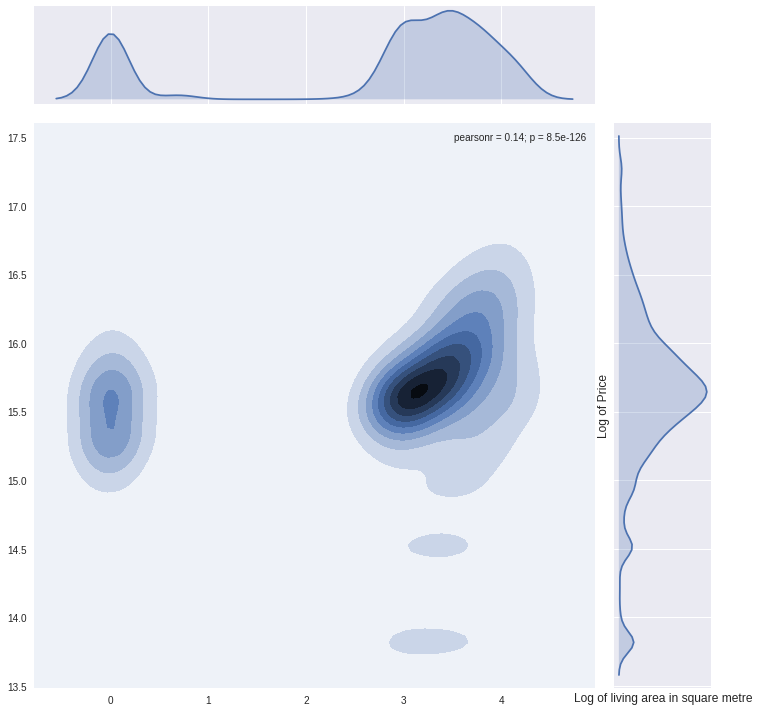

In [13]:
col = "life_sq"
train_df[col].fillna(0, inplace=True)
ulimit = np.percentile(train_df[col].values, 95)
llimit = np.percentile(train_df[col].values, 5)
train_df.loc[train_df[col]>ulimit,col] = ulimit
train_df.loc[train_df[col]<llimit,col] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.life_sq.values), y=np.log1p(train_df.price_doc.values), 
              kind='kde', size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of living area in square metre', fontsize=12)
plt.show()

** Floor **

We will see the count of floor

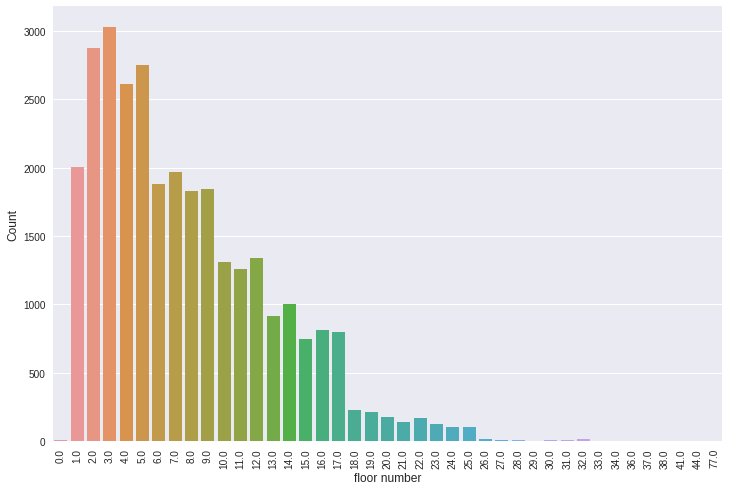

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Check how the price changes with floor

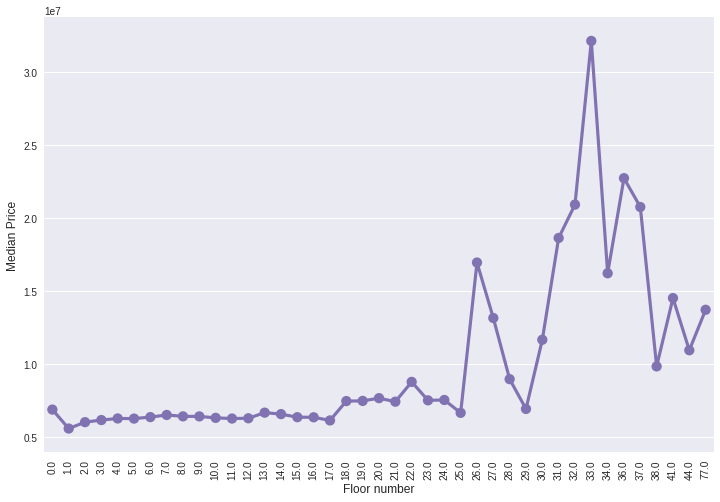

In [15]:
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[3])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

** Max Floor **

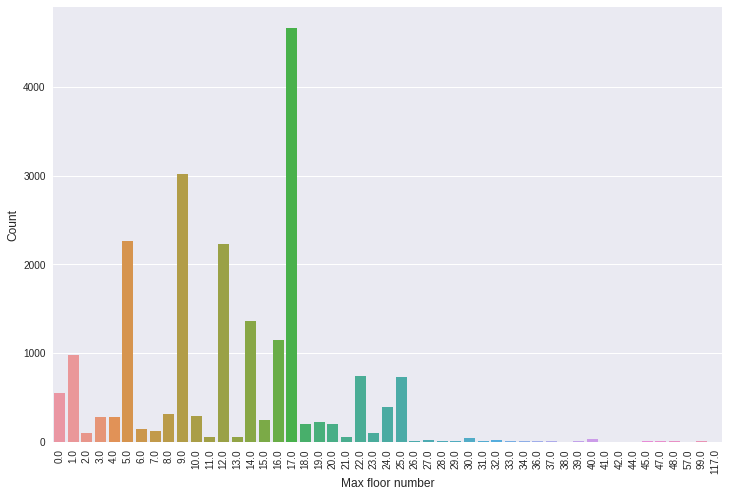

In [16]:
plt.figure(figsize=(12,8))
sns.countplot(x="max_floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Max floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We could see that there are few tall bars in between (at 5,9,12,17 - similar to drop in floors in the previous graph). May be there are some norms / restrictions on the number of maximum floors present(?).
Now let us see how the median prices vary with the max floors.

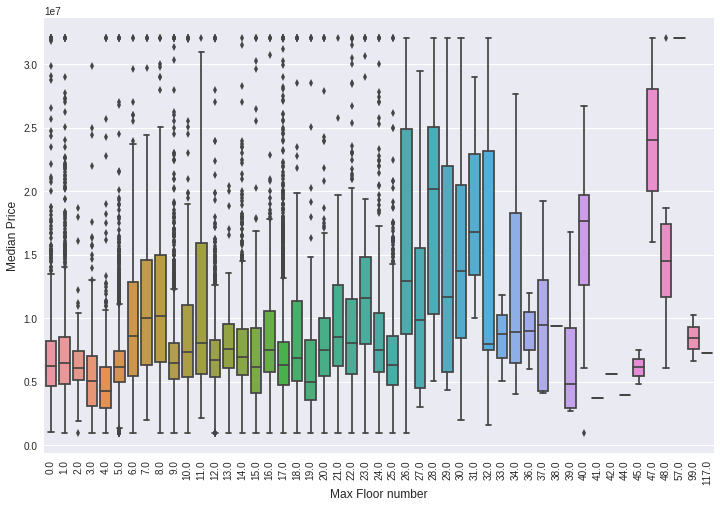

In [17]:
plt.figure(figsize=(12,8))
sns.boxplot(x="max_floor", y="price_doc", data=train_df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

# Feature Engineering 

Feature Engineering is the main aspect of Machine learning problems. Here we will work upon creating addition features that can be better predictor of price

In [26]:
train_df = pd.read_csv("train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'])
train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')
print(train_df.shape, test_df.shape)

# truncate the extreme values in price_doc #
ulimit = np.percentile(train_df.price_doc.values, 99)
llimit = np.percentile(train_df.price_doc.values, 1)
train_df.loc[train_df['price_doc']>ulimit,'price_doc'] = ulimit
train_df.loc[train_df['price_doc']<llimit,'price_doc'] = llimit

(30471, 391) (7662, 390)


After looking into the data there are 3 variables which are numeric but their data types are object so we will rectify them forst then move on, these variables are :
- child_on_acc_pre_school - it has '#!" as some values and comma formatted numeric values
- modern_education_share - this has comma formatted numeric values
- old_education_build_share - this has comma formatted numeric values


In [27]:
#remove the special characters first
try:
    train_df.loc[train_df['child_on_acc_pre_school']== '#!','child_on_acc_pre_school'] = '0'
    test_df.loc[test_df['child_on_acc_pre_school']== '#!','child_on_acc_pre_school'] = '0'
except:
    pass

In [28]:
def rep_commas(a):
    return a.replace(',','')

In [29]:
train_df.child_on_acc_pre_school= train_df.child_on_acc_pre_school.fillna(0).astype(str).apply(rep_commas).astype(int)
train_df.modern_education_share = train_df.modern_education_share.fillna(0).astype(str).apply(rep_commas).astype(int)
train_df.old_education_build_share  =train_df.old_education_build_share.fillna(0).astype(str).apply(rep_commas).astype(int)
test_df.child_on_acc_pre_school= test_df.child_on_acc_pre_school.fillna(0).astype(str).apply(rep_commas).astype(int)
test_df.modern_education_share = test_df.modern_education_share.fillna(0).astype(str).apply(rep_commas).astype(int)
test_df.old_education_build_share  =test_df.old_education_build_share.fillna(0).astype(str).apply(rep_commas).astype(int)

Let's Encode the categorical variables first.

In [30]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        print(f)
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values.astype('str')) + list(test_df[f].values.astype('str')))
        train_df[f] = lbl.transform(list(train_df[f].values.astype('str')))
        test_df[f] = lbl.transform(list(test_df[f].values.astype('str')))

product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology


We also have some null values in the dataset. So one feature idea could be to use the count of nulls in the row.

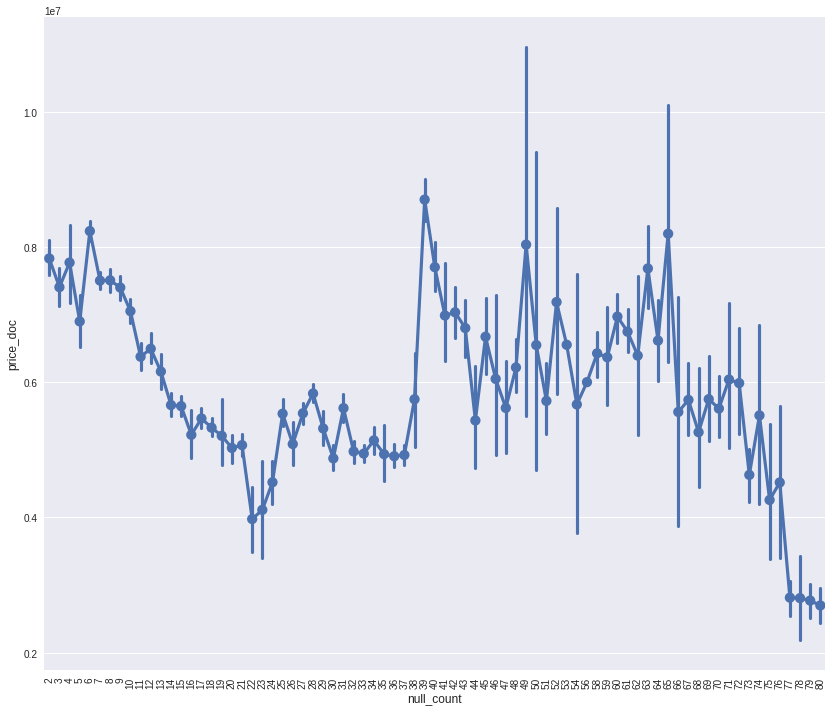

In [31]:
train_df["null_count"] = train_df.isnull().sum(axis=1)
test_df["null_count"] = test_df.isnull().sum(axis=1)

plt.figure(figsize=(14,12))
sns.pointplot(x='null_count', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('null_count', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Now let us impute the missing values with some value which is outside the range of values of the column, say -99.

In [33]:
#train_df.fillna(-99, inplace=True)
#test_df.fillna(-99, inplace=True)
train_df.loc[train_df["floor"] > train_df["max_floor"],"max_floor"] = train_df.loc[train_df["floor"] > train_df["max_floor"],"floor"]

In [68]:
train_df.build_year.value_counts()

-99.0      12975
 2014.0      919
 2016.0      867
 2015.0      825
 2000.0      661
 2001.0      545
 1965.0      494
 2013.0      464
 1970.0      441
 1969.0      407
 1968.0      389
 1967.0      384
 1972.0      360
 1974.0      357
 1971.0      353
 1966.0      348
 1960.0      344
 1962.0      338
 1973.0      333
 1963.0      325
 1964.0      315
 1975.0      309
 1961.0      297
 1976.0      263
 1977.0      260
 2006.0      242
 1979.0      236
 1978.0      235
 2008.0      234
 2012.0      233
           ...  
 1930.0        6
 1931.0        6
 1890.0        5
 1936.0        5
 1910.0        5
 1912.0        5
 1915.0        5
 1947.0        4
 1924.0        3
 1949.0        3
 1914.0        3
 1907.0        2
 1946.0        2
 1941.0        2
 1900.0        2
 1896.0        2
 1943.0        2
 1860.0        2
 1691.0        1
 1906.0        1
 1948.0        1
 1876.0        1
 1895.0        1
 1904.0        1
 1925.0        1
 1920.0        1
 1905.0        1
 1911.0       

In [62]:
train_df.loc[((train_df["material"] == 5.0 )& (train_df["build_year"] == -99.0)),"build_year"] = 1970.0

We have a timestamp variable in the dataset and time could be one of an important factor determining the price. So let us extract some features out of the timestamp variable.

In [63]:
def make_features(df):
    #fill na
    df.fillna(-99, inplace=True)
    df.loc[df["build_year"] == 0.0,"build_year"] = 2000.0
    df.loc[df["build_year"] == 20052009.0 ,"build_year"] = 2005.0
    df.loc[df["build_year"] == 215.0 ,"build_year"] = 2015.0
    df.loc[df["build_year"] == 4965.0 ,"build_year"] = 1965.0
    df.loc[df["build_year"] == 71.0 ,"build_year"] = 1971.0
    df.loc[df["build_year"] == 1.0 ,"build_year"] = 2001.0
    df.loc[df["build_year"] == 3.0 ,"build_year"] = 2003.0
    df.loc[df["build_year"] == 20.0 ,"build_year"] = 2000.0
    df.loc[df["material"] == 3.0,"material"] = 1.0
    df.loc[((df["material"] == 5.0) & (df["build_year"] == -99.0)),"build_year"] = 1970.0
    df.loc[((df["material"] == 2.0 )& (df["build_year"] == -99.0)),"build_year"] = 1965.0
    df.loc[((df["material"] == 4.0) & (df["build_year"] == -99.0)),"build_year"] = 2016.0
    df.loc[((df["material"] == 6.0) & (df["build_year"] == -99.0)),"build_year"] = 2016.0
    df.loc[:,'male_f_p' ]= df.loc[:,'male_f']/np.maximum(df.loc[:,'full_all'],1)

    df.loc[:,'young_all_p' ]= df.loc[:,'young_all']/np.maximum(df.loc[:,'full_all'],1)
    df.loc[:,'young_male_p' ]= df.loc[:,'young_male']/np.maximum(df.loc[:,'full_all'],1)

    df.loc[:,'work_all_p' ]= df.loc[:,'work_all']/np.maximum(df.loc[:,'full_all'],1)
    df.loc[:,'work_male_p' ]= df.loc[:,'work_male']/np.maximum(df.loc[:,'full_all'],1)

    df.loc[:,'ekder_all_p' ]= df.loc[:,'ekder_all']/np.maximum(df.loc[:,'full_all'],1)
    df.loc[:,'ekder_male_p' ]= df.loc[:,'ekder_male']/np.maximum(df.loc[:,'full_all'],1)

    df.loc[:,'0_6_all_p' ]= df.loc[:,'0_6_all']/np.maximum(df.loc[:,'full_all'],1)
    df.loc[:,'0_6_male_p' ]= df.loc[:,'0_6_male']/np.maximum(df.loc[:,'full_all'],1)

    df.loc[:,'7_14_all_p' ]= df.loc[:,'7_14_all']/np.maximum(df.loc[:,'full_all'],1)
    df.loc[:,'7_14_male_p' ]= df.loc[:,'7_14_male']/np.maximum(df.loc[:,'full_all'],1)

    df.loc[:,'0_17_all_p' ]= df.loc[:,'0_17_all']/np.maximum(df.loc[:,'full_all'],1)
    df.loc[:,'0_17_male_p' ]= df.loc[:,'0_17_male']/np.maximum(df.loc[:,'full_all'],1)

    df.loc[:,'16_29_all_p' ]= df.loc[:,'16_29_all']/np.maximum(df.loc[:,'full_all'],1)
    df.loc[:,'16_29_male_p' ]= df.loc[:,'16_29_male']/np.maximum(df.loc[:,'full_all'],1)

    df.loc[:,'0_13_all_p' ]= df.loc[:,'0_13_all']/np.maximum(df.loc[:,'full_all'],1)
    df.loc[:,'0_13_male_p' ]= df.loc[:,'0_13_male']/np.maximum(df.loc[:,'full_all'],1)

    
    # year and month #
    df["yearmonth"] = df["timestamp"].dt.year*100 + df["timestamp"].dt.month
    # year and week #
    df["yearweek"] = df["timestamp"].dt.year*100 + df["timestamp"].dt.weekofyear
    # year #
    df["year"] = df["timestamp"].dt.year
    # month of year #
    df["month_of_year"] = df["timestamp"].dt.month
    # week of year #
    df["week_of_year"] = df["timestamp"].dt.weekofyear
    # day of week #
    df["day_of_week"] = df["timestamp"].dt.weekday
    #if floor > max_floor then floor = max_floor
    
    # ratio of living area to full area #
    df["ratio_life_sq_full_sq"] = df["life_sq"] / np.maximum(df["full_sq"].astype("float"),1)

    df.loc[df["ratio_life_sq_full_sq"]<0,"ratio_life_sq_full_sq"] = 0
    df.loc[df["ratio_life_sq_full_sq"]>1,"ratio_life_sq_full_sq"] = 1
    # ratio of kitchen area to living area #
    df["ratio_kitch_sq_life_sq"] = df["kitch_sq"] / np.maximum(df["life_sq"].astype("float"),1)

    df.loc[df["ratio_kitch_sq_life_sq"]<0,"ratio_kitch_sq_life_sq"] = 0
    df.loc[df["ratio_kitch_sq_life_sq"]>1,"ratio_kitch_sq_life_sq"] = 1
    # ratio of kitchen area to full area #
    df["ratio_kitch_sq_full_sq"] = df["kitch_sq"] / np.maximum(df["full_sq"].astype("float"),1)

    df.loc[df["ratio_kitch_sq_full_sq"]<0,"ratio_kitch_sq_full_sq"] = 0
    df.loc[df["ratio_kitch_sq_full_sq"]>1,"ratio_kitch_sq_full_sq"] = 1
    # floor of the house to the total number of floors in the house #
    df["ratio_floor_max_floor"] = df["floor"] / df["max_floor"].astype("float")
    
    df.loc[df["floor"] > df["max_floor"],"max_floor"] = df.loc[df["floor"] > df["max_floor"],"floor"]
    # if life_sq > full sq then full sq
    df.loc[df["life_sq"] > df["full_sq"],"life_sq"] = df.loc[df["life_sq"] > df["full_sq"],"full_sq"]
    
    # num of floor from top #
    df["floor_from_top"] = df["max_floor"] - df["floor"]
    df["extra_sq"] = df["full_sq"] - df["life_sq"]
    df["age_of_building"] = df["build_year"] -df["year"]
    df["ratio_preschool"] = df["children_preschool"] / df["preschool_quota"].astype("float")
    df["ratio_school"] = df["children_school"] / df["school_quota"].astype("float")
    df["ratio_preschool"] = df["children_preschool"] / df["preschool_quota"].astype("float")
    df["ratio_school"] = df["children_school"] / df["school_quota"].astype("float")
    return df

In [64]:
train_df = make_features(train_df)
test_df = make_features(test_df)

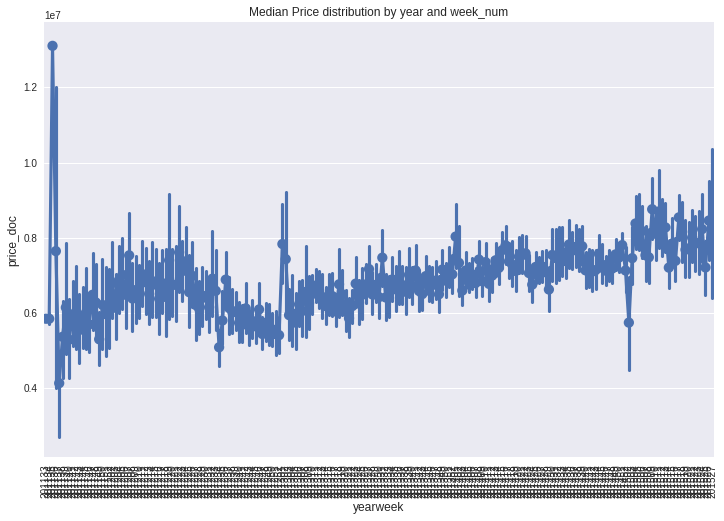

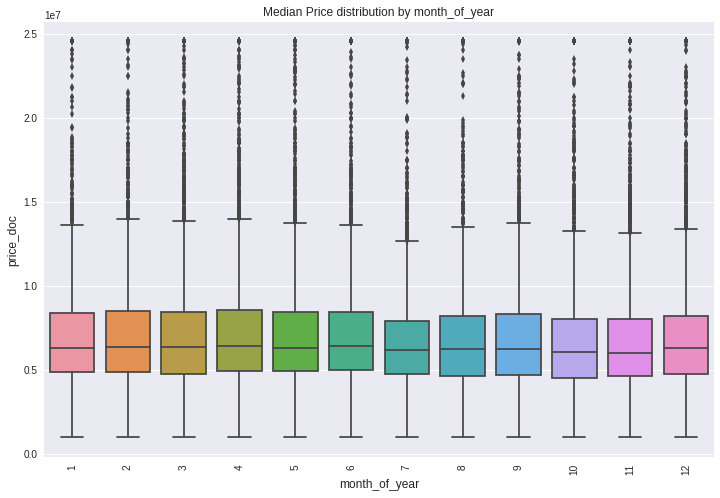

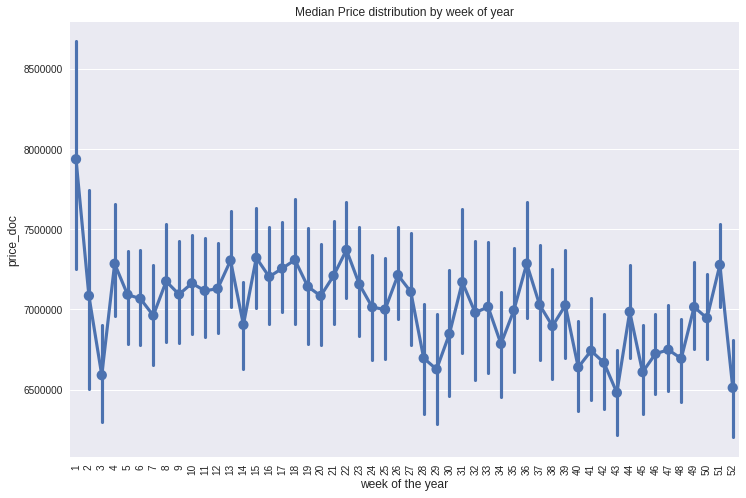

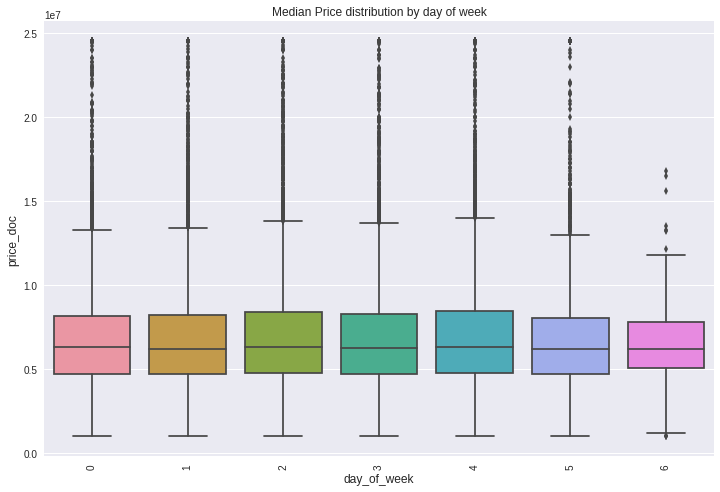

In [26]:


plt.figure(figsize=(12,8))
sns.pointplot(x='yearweek', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('yearweek', fontsize=12)
plt.title('Median Price distribution by year and week_num')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(x='month_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('month_of_year', fontsize=12)
plt.title('Median Price distribution by month_of_year')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.pointplot(x='week_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('week of the year', fontsize=12)
plt.title('Median Price distribution by week of year')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(x='day_of_week', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('day_of_week', fontsize=12)
plt.title('Median Price distribution by day of week')
plt.xticks(rotation='vertical')
plt.show()

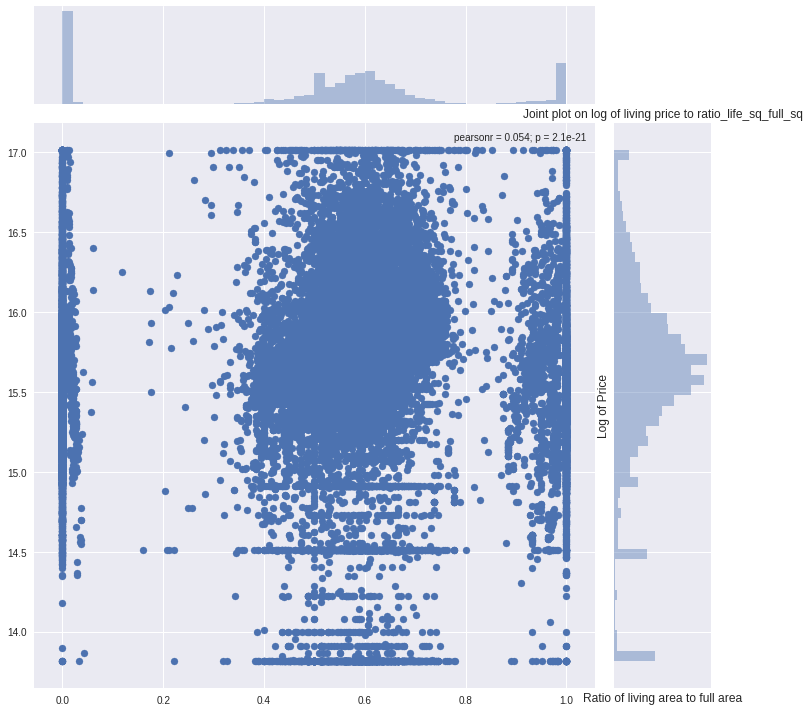

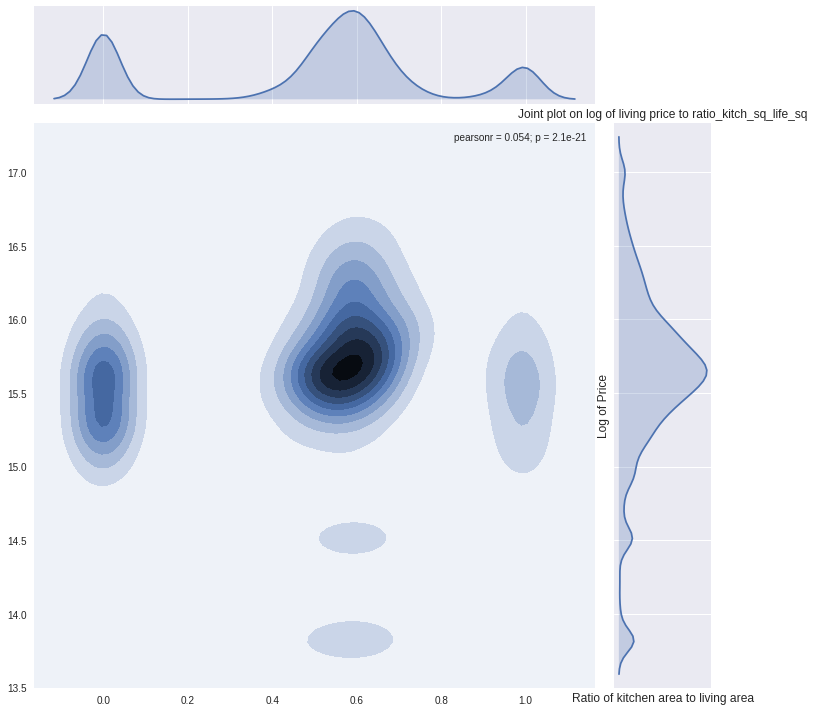

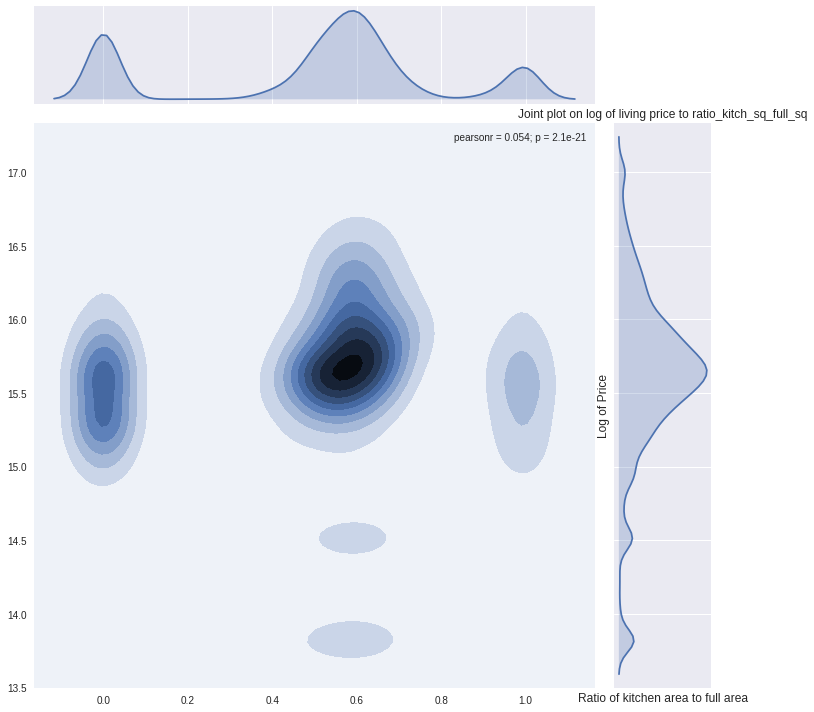

In [27]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.ratio_life_sq_full_sq.values, y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Ratio of living area to full area', fontsize=12)
plt.title("Joint plot on log of living price to ratio_life_sq_full_sq")
plt.show()

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.ratio_life_sq_full_sq.values, y=np.log1p(train_df.price_doc.values), 
              kind='kde',size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Ratio of kitchen area to living area', fontsize=12)
plt.title("Joint plot on log of living price to ratio_kitch_sq_life_sq")
plt.show()

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.ratio_life_sq_full_sq.values, y=np.log1p(train_df.price_doc.values), 
              kind='kde',size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Ratio of kitchen area to full area', fontsize=12)
plt.title("Joint plot on log of living price to ratio_kitch_sq_full_sq")
plt.show()

In [13]:
def add_count(df, group_col):
    grouped_df = df.groupby(group_col)["id"].aggregate("count").reset_index()
    grouped_df.columns = [group_col, "count_"+group_col]
    df = pd.merge(df, grouped_df, on=group_col, how="left")
    return df

train_df = add_count(train_df, "yearmonth")
test_df = add_count(test_df, "yearmonth")

train_df = add_count(train_df, "yearweek")
test_df = add_count(test_df, "yearweek")

In [17]:
train_X = train_df.drop(["id","ID_metro","ID_railroad_station_walk","ID_railroad_station_avto",
                         "ID_big_road1","ID_big_road2","ID_railroad_terminal","ID_bus_terminal",
                         "timestamp",'male_f','female_f','young_all','young_male','young_female',
                         'work_all','work_male','work_female','ekder_all','ekder_male','ekder_female',
                         '0_6_all','0_6_male','0_6_female','7_14_all','7_14_male','7_14_female','0_17_all',
                         '0_17_male','0_17_female','16_29_all','16_29_male','16_29_female','0_13_all',
                         '0_13_male','0_13_female', "price_doc"], axis=1)
test_X = test_df.drop(["id","ID_metro","ID_railroad_station_walk","ID_railroad_station_avto",
                         "ID_big_road1","ID_big_road2","ID_railroad_terminal","ID_bus_terminal",
                         "timestamp",'male_f','female_f','young_all','young_male','young_female',
                         'work_all','work_male','work_female','ekder_all','ekder_male','ekder_female',
                         '0_6_all','0_6_male','0_6_female','7_14_all','7_14_male','7_14_female','0_17_all',
                         '0_17_male','0_17_female','16_29_all','16_29_male','16_29_female','0_13_all',
                         '0_13_male','0_13_female'] , axis=1)

We could potentially add more variables like this. But for now let us start with model building using these additional variables. Let us drop the variables which are not needed in model building.

Since our metric is "RMSLE", let us use log of the target variable for model building rather than using the actual target variable.

In [18]:
train_y = np.log1p(train_df.price_doc.values)

** Validation Methodology: **
But before building our models, let us do some local validation by splitting the train dataset.
In this competition, the train and test set are from different time periods and so let us use the last 1 year as validation set for building our models and rest as model development set.

In [19]:
val_time = 201407
dev_indices = np.where(train_X["yearmonth"]<val_time)
val_indices = np.where(train_X["yearmonth"]>=val_time)
dev_X = train_X.ix[dev_indices]
val_X = train_X.ix[val_indices]
dev_y = train_y[dev_indices]
val_y = train_y[val_indices]
print(dev_X.shape, val_X.shape)

(20483, 399) (9988, 399)


Let us build xgboost model using these variables and check the score.

In [20]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'min_child_weight':1,
    'silent': 1,
    'seed':0
}

xgtrain = xgb.DMatrix(dev_X, dev_y, feature_names=dev_X.columns)
xgtest = xgb.DMatrix(val_X, val_y, feature_names=val_X.columns)
watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
num_rounds = 500 # Increase the number of rounds while running in local
model = xgb.train(xgb_params, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)

[0]	train-rmse:14.3231	test-rmse:14.4522
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[20]	train-rmse:5.1582	test-rmse:5.26815
[40]	train-rmse:1.90514	test-rmse:2.00195
[60]	train-rmse:0.813212	test-rmse:0.875567
[80]	train-rmse:0.522925	test-rmse:0.552088
[100]	train-rmse:0.466695	test-rmse:0.470292
[120]	train-rmse:0.454139	test-rmse:0.453146
[140]	train-rmse:0.448202	test-rmse:0.445474
[160]	train-rmse:0.443808	test-rmse:0.442489
[180]	train-rmse:0.439638	test-rmse:0.441159
[200]	train-rmse:0.43627	test-rmse:0.443798
[220]	train-rmse:0.432917	test-rmse:0.443546
Stopping. Best iteration:
[180]	train-rmse:0.439638	test-rmse:0.441159



[0]	train-rmse:14.3637	test-rmse:14.3638
[5]	train-rmse:11.1202	test-rmse:11.1203
[10]	train-rmse:8.61145	test-rmse:8.61155
[15]	train-rmse:6.67145	test-rmse:6.67146
[20]	train-rmse:5.17223	test-rmse:5.17253
[25]	train-rmse:4.01423	test-rmse:4.01471
[30]	train-rmse:3.12127	test-rmse:3.122
[35]	train-rmse:2.43391	test-rmse:2.43507
[40]	train-rmse:1.90688	test-rmse:1.90869
[45]	train-rmse:1.50481	test-rmse:1.50725
[50]	train-rmse:1.20049	test-rmse:1.20401
[55]	train-rmse:0.973042	test-rmse:0.977803
[60]	train-rmse:0.80617	test-rmse:0.812551
[65]	train-rmse:0.686223	test-rmse:0.694361
[70]	train-rmse:0.602672	test-rmse:0.61272
[75]	train-rmse:0.545995	test-rmse:0.557868
[80]	train-rmse:0.508438	test-rmse:0.522008
[85]	train-rmse:0.48376	test-rmse:0.498982
[90]	train-rmse:0.467818	test-rmse:0.484421
[95]	train-rmse:0.45745	test-rmse:0.475346
[100]	train-rmse:0.450582	test-rmse:0.469509
[105]	train-rmse:0.445853	test-rmse:0.465786
[110]	train-rmse:0.442372	test-rmse:0.463218
[115]	train-rms

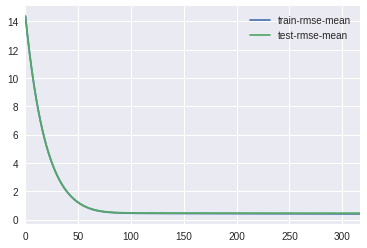

In [21]:
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns)
dtest = xgb.DMatrix(test_X, feature_names=test_X.columns)
watchlist = [ (dtrain,'train'), (dtest, 'test') ]

cv_output = xgb.cv(xgb_params, dtrain,num_rounds, 
                   early_stopping_rounds=50, verbose_eval=5, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [22]:
num_boost_rounds = model.best_iteration
model2 = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)


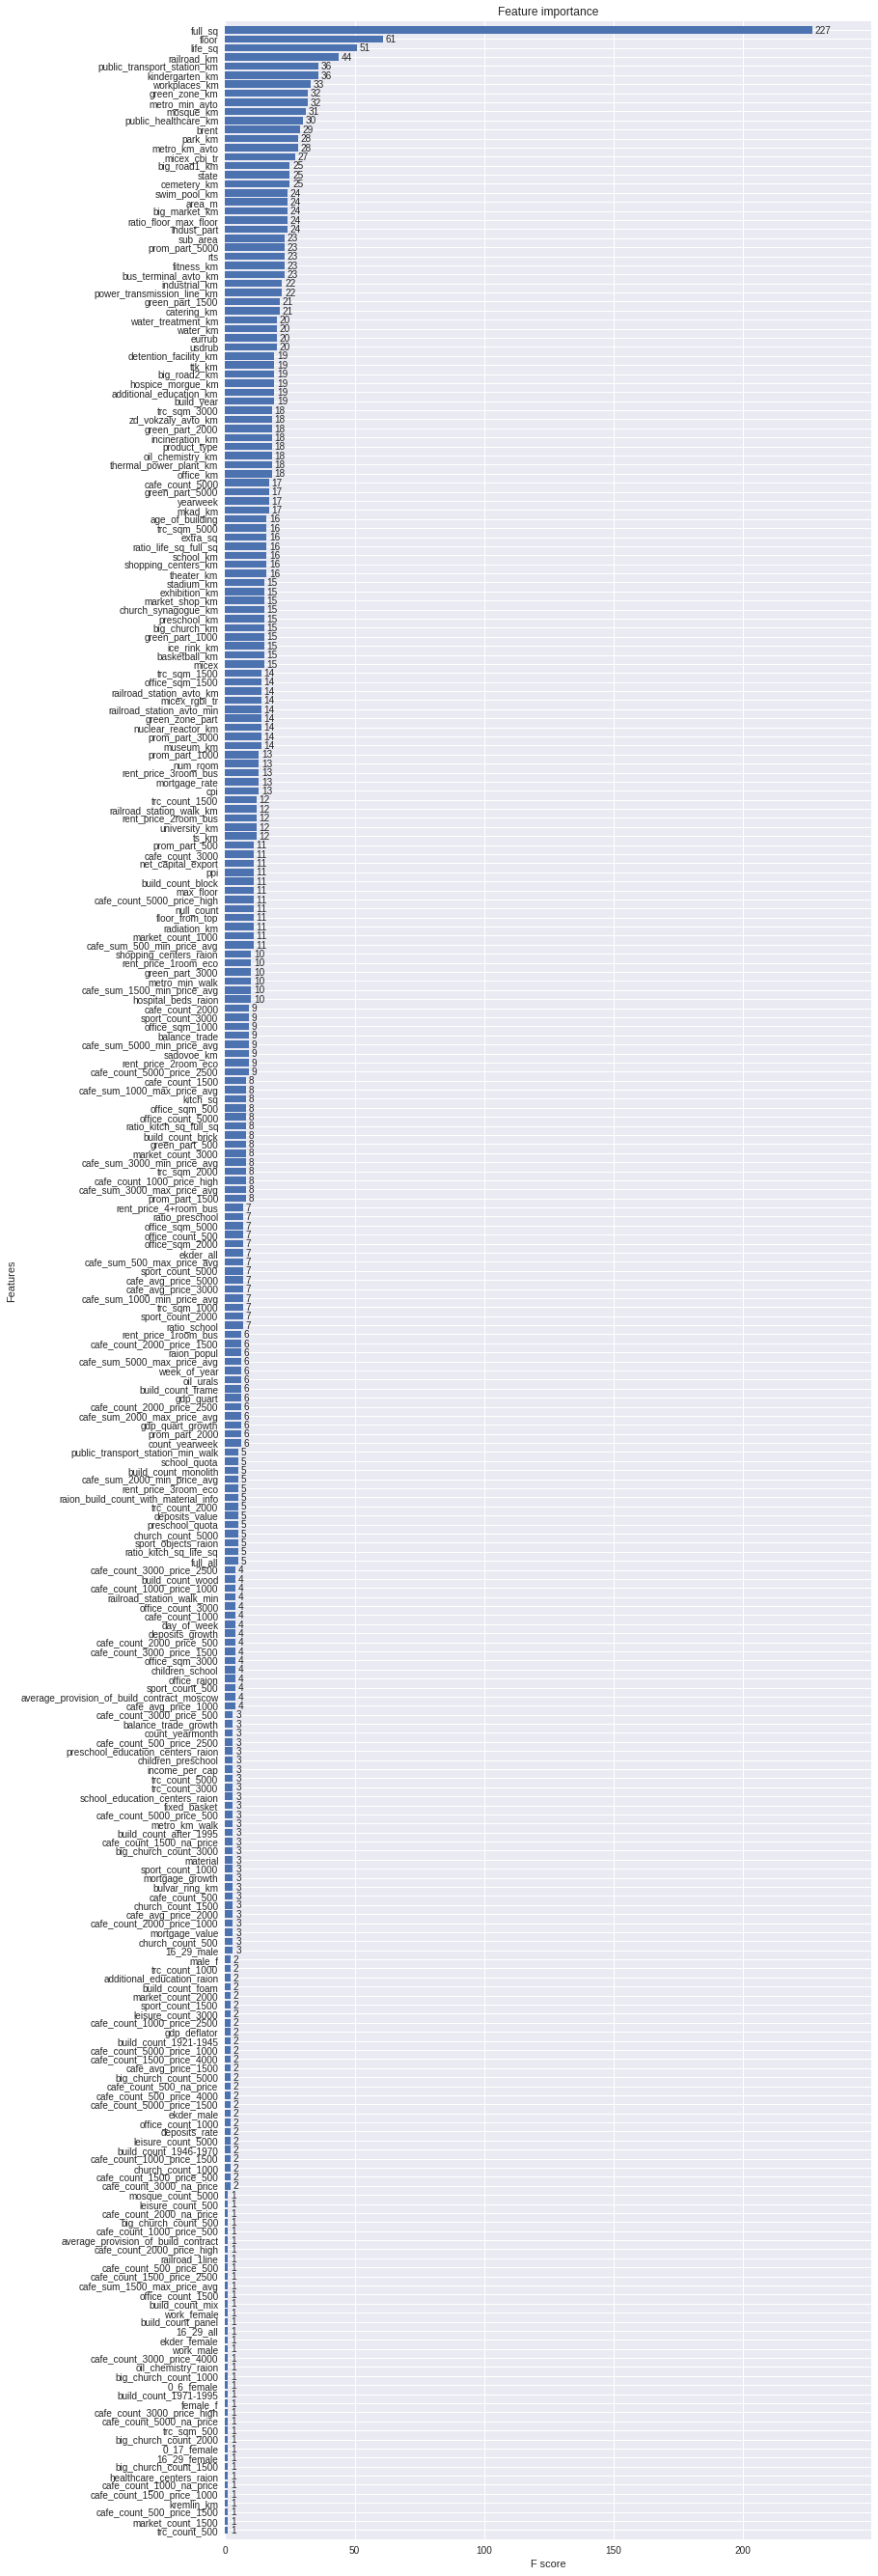

In [23]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,48))
xgb.plot_importance(model,  height=0.8, ax=ax)
plt.show()

In [24]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': test_df.id, 'price_doc': np.exp(y_predict)-1})
output.head()

,id,price_doc
0,30474,4820321.5
1,30475,6459956.5
2,30476,4824930.0
3,30477,4743467.5
4,30478,4642542.0


In [25]:
output.to_csv('xgbSub1.csv', index=False)

In [56]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'min_child_weight':1,
    'silent': 1,
    'seed':0
}
param_grid = {}
param_grid['eta'] = [0.01,0.03,0.05,0.07]
param_grid['max_depth'] = [list(range(2,10,2))]
param_grid['subsample'] = [.5,.7,.9]
param_grid['colsample_bytree'] = [.5,.7,.9]
param_grid['objective'] = ['reg:linear']
param_grid['eval_metric'] = ['rmse']
param_grid['min_child_weight'] = [1,2,4]
param_grid['silent'] = [1]
param_grid['seed'] = [0]
param_grid

{'colsample_bytree': [0.5, 0.7, 0.9],
 'eta': [0.01, 0.03, 0.05, 0.07],
 'eval_metric': ['rmse'],
 'max_depth': [[2, 4, 6, 8]],
 'min_child_weight': [1, 2, 4],
 'objective': ['reg:linear'],
 'seed': [0],
 'silent': [1],
 'subsample': [0.5, 0.7, 0.9]}

# Parameter Tuning

Let's tune Xgboost parameters and increase the accuracy with this approach.
To tune any parameter we have to use GridSearchCv from sklearn.model_selection

In [41]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'reg:linear'}
optimized_GBM = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1) 

Now let’s run our grid search with 5-fold cross-validation and see which parameters perform the best.

In [ ]:
optimized_GBM.fit(train_X, train_y)

In [ ]:
optimized_GBM.grid_scores_

In [ ]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'reg:linear', 'max_depth': 3, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                            cv_params, 
                             scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1)


In [ ]:
optimized_GBM.fit(train_X, train_y)

In [ ]:
optimized_GBM.grid_scores_

In [ ]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [ ]:
cv_xgb.tail(5)

In [ ]:
xgb_model = xgb.train(xgb_params, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)

In [ ]:
clf = GridSearchCV(xgb_model,param_grid,scoring = 'rmse',verbose = 1,cv = 5,n_jobs = -1)
clf.fit(X,y)

In [ ]:
'''if not os.path.isfile(pickle_file):
    clf = GridSearchCV(xgb_model,param_grid,scoring = 'r2',verbose = 1,cv = 5,n_jobs = -1)
    clf.fit(X,y)
    try:
        with open(pickle_file,'wb') as f:
            pickle.dump(clf,f,pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save output to ',pickle_filename, ':',e)


else:
    #Pickle the output
    with open(pickle_file,'rb') as f:
        save = pickle.load(f)
        clf = save['clf']
print(clf.best_score_)
print(clf.best_params_)'''

In [ ]:
'''y_pred = clf.predict(X_new)

y_out = np.exp(y_pred)

#Create a DataFrame that only contains the IDs and predicted values
if not os.path.isfile(output_file):
    pd.DataFrame({'id':test.id, 'price_doc': y_out}).set_index('id').to_csv(output_file)
else:
    print('Output file', output_file, ' already exists into the location')'''